In [1]:
import os, sys, time, re, random, math, json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import math

%matplotlib inline
print(sys.version)

3.8.10 (tags/v3.8.10:3d8993a, May  3 2021, 11:48:03) [MSC v.1928 64 bit (AMD64)]


## Load the Sample Dataset

Along with this jupyter notebook you should have received one other file called `berlin_ards.json` (Please unzip if you receive a zip file). It is a json file containing the data that we will be working with for this project. Load it with the cell below

In [2]:
with open('berlin_ards.json') as json_file:
    berlin_ards = json.load(json_file)

## Introduction to the Sample Dataset

This sample dataset is a subset taken from a freely accessible critical care database. `berlin_ards` above is a dictionary of patient encounters. An encounter is one hospitalization. One patient can have multiple admissions to the hospital. Each admission would have a unique encounter_ID. In this dataset the times have been modified but the time intervals are real. Run the cells below to get acquainted.

In [3]:
keys = list(berlin_ards.keys())
num_encs = len(keys)
print("There are {} patient encounters in this dataset".format(num_encs))

There are 8709 patient encounters in this dataset


In [4]:
print("{} is an example of an encounter ID".format(keys[0]))

200021 is an example of an encounter ID


plug the encounter ID into the dictionary to see information about this patient's encounter

here is some basic information about this hospitalization and all the keys to the other types of data for this encounter

In [5]:
enc = berlin_ards[keys[0]]
print('')
print(enc['Info'])
enc.keys()


{'age': 60.0, 'gender': 'M', 'weight': 82.6, 'subject_id': '61691', 'is_in_hospital_death': False, 'is_Berlin_ARDS': False, 'first_measurement_time': '2114-12-26T20:40:00', 'is_Berlin_time': '2114-12-26T21:23:00', 'last_measurement_time': '2114-12-27T22:00:00'}


dict_keys(['Info', 'feature_matrix_row_names', 'feature_sampling_interval_minutes', 'feature_matrix'])

Most of this you will have to figure out for yourself, but lets go over some special data components

First, we have given you a feature matrix of timeseries features where each row is a different vital sign or lab measurement and each column is a different timestep starting with column 0 = time zero.  

As an example, here are the first 24 hours of oxygen saturation (SpO2) measurements. The first SpO2 measurement was made 60 minutes into the stay, which is why the first 2 columns are not a number

In [6]:
print(enc['feature_matrix_row_names'])
period = enc['feature_sampling_interval_minutes']
print('number of features', len(enc['feature_matrix_row_names']))
print('minutes between timesteps', period)
feature_index = 5
print(enc['feature_matrix_row_names'][feature_index])
feature_matrix = np.array(enc['feature_matrix'])
print(feature_matrix[feature_index,:int(24*60/period)])
print(feature_matrix.shape)

['SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets']
number of features 9
minutes between timesteps 30
SpO2
[nan nan 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 98. 98. 96. 96. 94.
 94. 97. 97. 96. 96. 96. 96. 94. 94. 94. 94. 94.]
(9, 51)


### Sanity Check

The length of stay should be within one period of the amount of time represented by the feature matrix

In [7]:
start_time = datetime.strptime(enc['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
stop_time = datetime.strptime(enc['Info']['last_measurement_time'], '%Y-%m-%dT%H:%M:%S')

lenofstay_mins = (stop_time - start_time).total_seconds()/60
print((lenofstay_mins/60), 'hours', feature_matrix.shape[1]*period/60, 'hours')

25.333333333333332 hours 25.5 hours


# Exploring the Data

For the 3 features: 

    a. Systolic Blood Pressure (SysABP)

    b. Temperature (Temp) 

    c. White Blood Cell Count (WBC)
    
## TODOs:

1. Generate figures to describe the distribution of these features: ie their variability and central tendency. Make the figures as easy to read and self-explainatory as possible as if you were going to publish them. 

2. Look up each these 3 features. Have you plotted a clinically plausible, ie physiologically distributed, spread of measurements that you would expect for each feature ? 

    - Yes, the normal Systolic Blood Pressure is around 110-120(mmHg).
    - Yes, The normal Temperature is around 37 Celsius
    - Yes, the normal WBC is 4.5k - 11k WBC's per microliter
    
    
3. What are the units of measurment each feature likely uses ? 

    A) Systolic Blood Pressure: units of millimeters of mercury (mmHg)
    
    B) Temperature: Celsius
    
    C) White Blood Cell Count: K/uL
    

# EDA/Sample Distributions

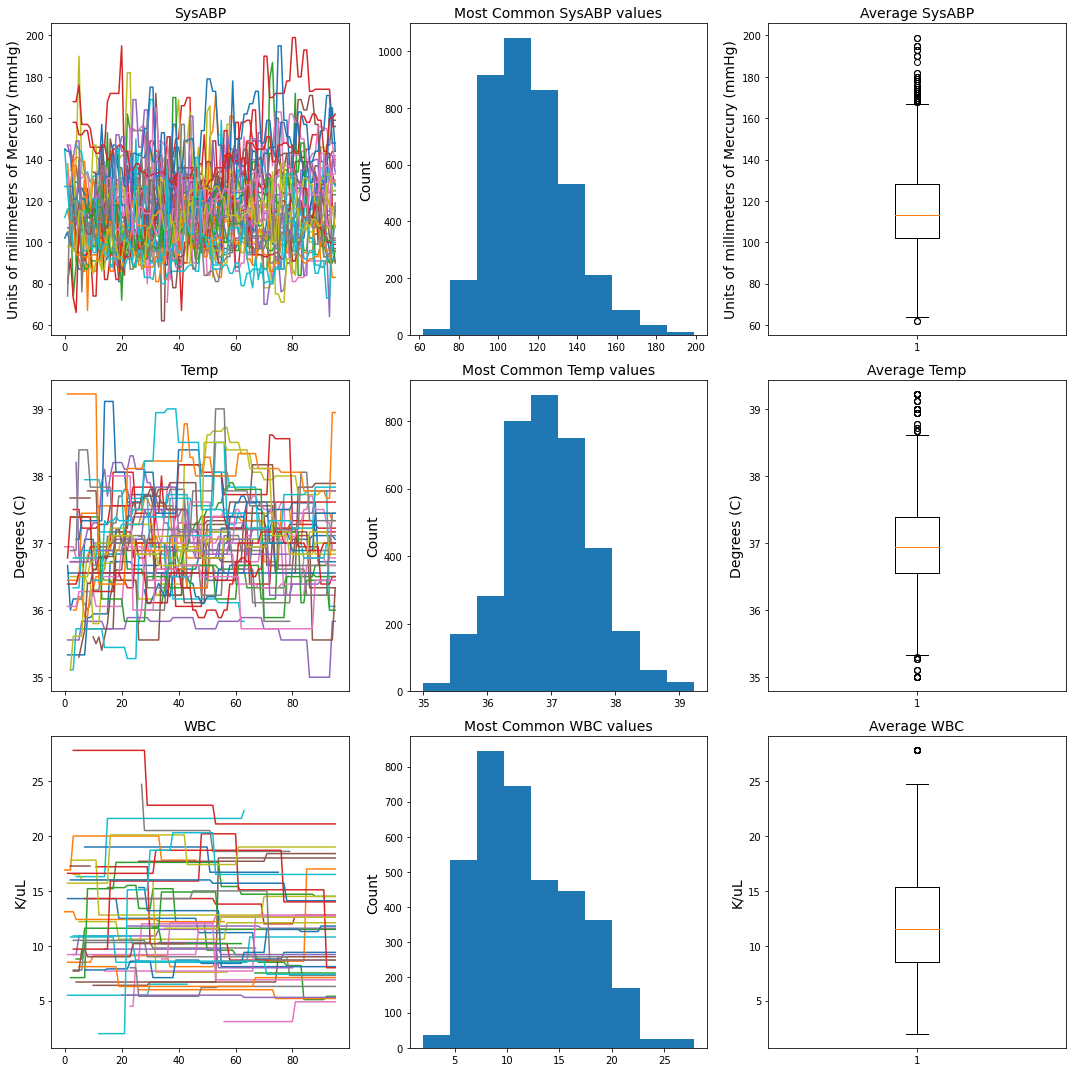

In [8]:
fig, axs = plt.subplots(3,3, figsize = (15,15))
l1 = []
l2 = []
l3 = []
ind = [0, 3, 7]
features = ['SysABP', 'Temp', 'WBC']
hist_list = [l1, l2, l3]
samples = random.sample(list(range(len(keys))), 50)
for i in range(3):

    for x in samples:
        period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
        axs[i][0].plot(berlin_ards[keys[x]]['feature_matrix'][ind[i]][:round(24*2*60/period)])
        hist_list[i] = hist_list[i] + berlin_ards[keys[x]]['feature_matrix'][ind[i]][:round(24*2*60/period)] 
        axs[i][0].set_title(features[i], fontsize = 14)
        
    axs[i][1].hist(hist_list[i])
    axs[i][1].set_title('Most Common ' + features[i] + ' values', fontsize = 14)
    axs[i][1].set_ylabel('Count', fontsize = 14)
    w = np.array(hist_list[i])
    w = w[~np.isnan(w)]
    axs[i][2].boxplot(w)
    axs[i][2].set_title('Average ' + features[i], fontsize = 14)
    

for i in [0, 2]:
    axs[0][i].set_ylabel('Units of millimeters of Mercury (mmHg)', fontsize = 14)
    axs[1][i].set_ylabel('Degrees (C)', fontsize = 14)
    axs[2][i].set_ylabel('K/uL', fontsize = 14)
plt.tight_layout()

# Machine Learning

ARDS or [Acute respiratory distress syndrome](https://www.uptodate.com/contents/acute-respiratory-distress-syndrome-clinical-features-diagnosis-and-complications-in-adults) is a difficult disease both to define and also to predict. The definition of ARDS we will be using is the Berlin Criteria (Lung imaging shows Bilateral Infiltrates and PaO2/FiO2 is < 300). We are going to have you design and train an algorithm to predict the onset of ARDS before it occurs as best you can using the limited data in this sample dataset. The target labels are provided for you for each patient encounter, see below:

In [9]:
encounter_index = 1
print('Did this patient develope ARDS according to the Berlin Criteria?',berlin_ards[keys[encounter_index]]['Info']['is_Berlin_ARDS'])
print('Time Berlin Criteria was evaluated',
      berlin_ards[keys[encounter_index]]['Info']['is_Berlin_time'])

Did this patient develope ARDS according to the Berlin Criteria? False
Time Berlin Criteria was evaluated 2127-03-03T17:27:00


### Guidelines

a. You can choose which machine learning algorithm and python packages to use 

b. You can choose which features to use. 

c. Only use features as inputs to the algorithm that are available at or before the time you plan to make the prediction. If ARDS occurs at 48 hours into the hospitalization and your machine learning algorithm makes a prediction at 24 hours into the hospitalization, make sure you are not using information from the dataset that becomes available only after 24 hours. 


## TODOs:

1. Set aside a portion of the encounters to use as the hold out test set.

2. Train and validate the algorithm on the remaining dataset.

2. Plot the area under the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) aka AUC on the hold out test set. 

3. Generate a figure to help us understand how the algorithm makes it's decisions. ie address model interpretability. 

In [10]:
#### Which cases were True and False by Index #####
count = 0
true_cases = []
false_cases = []
berlin_true = {}
while count < len(keys):
    if berlin_ards[keys[count]]['Info']['is_Berlin_ARDS'] == True:
        true_cases.append(count)
        count = count + 1      
    else:
        false_cases.append(count)
        count = count + 1

#### WRITE CODE HERE #####

In [11]:
len(true_cases)

439

In [12]:
len(false_cases)

8270

# Gender/Age 

Features: 'SysABP', 'DiasABP', 'HR', 'Temp', 'RespRate', 'SpO2', 'Creatinine', 'WBC', 'Platelets'

In [13]:
#### WRITE CODE HERE #####
'"Average Ages for Both Classes and gender count"'
count2_male_t = 0
count2_female_t = 0
count2_male_f = 0
count2_female_f = 0
age_male_true = 0
age_male_false = 0
age_female_true = 0
age_female_false = 0

for x in true_cases:
    if berlin_ards[keys[x]]['Info']['gender'] == 'M':
        age_male_true = age_male_true + berlin_ards[keys[x]]['Info']['age'] 
        count2_male_t += 1
    else:
        age_female_true = age_female_true + berlin_ards[keys[x]]['Info']['age'] 
        count2_female_t += 1

for x in false_cases:
    if berlin_ards[keys[x]]['Info']['gender'] == 'M':
        age_male_false = age_male_false + berlin_ards[keys[x]]['Info']['age'] 
        count2_male_f += 1
    else:
        age_female_false = age_female_false + berlin_ards[keys[x]]['Info']['age'] 
        count2_female_f += 1

In [14]:
avg_male_true = age_male_true/count2_male_t
avg_female_true = age_female_true/count2_female_t
avg_male_false = age_male_false/count2_male_f
avg_female_false = age_female_false/count2_female_f

# Plotting Gender/Age differences by Class

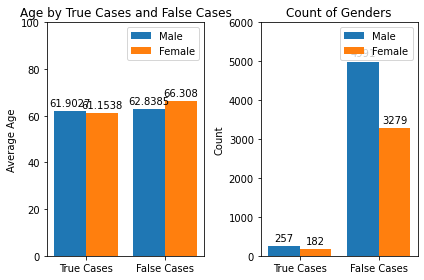

In [15]:
plt.subplot(1, 2, 1)
gender = ['True Cases', 'False Cases']

x = np.arange(len(gender))
y1 = [avg_male_true, avg_male_false]
y2 = [avg_female_true, avg_female_false]
width = 0.40
  
# plot data in grouped manner of bar type
y = plt.bar(x-0.2, y1, width, label = 'Male')
z = plt.bar(x+0.2, y2, width, label = 'Female')
plt.ylabel('Average Age')
plt.title('Age by True Cases and False Cases')
plt.xticks(x, gender)
plt.bar_label(y, padding=3)
plt.bar_label(z, padding=3)
plt.ylim((0,100))

plt.legend(['Male', 'Female'])
plt.tight_layout()

plt.subplot(1, 2, 2)
gender = ['True Cases', 'False Cases']

x = np.arange(len(gender))
y1 = [count2_male_t, count2_male_f]
y2 = [count2_female_t, count2_female_f]
width = 0.40
  
# plot data in grouped manner of bar type
y = plt.bar(x-0.2, y1, width, label = 'Male')
z = plt.bar(x+0.2, y2, width, label = 'Female')
plt.ylabel('Count')
plt.title('Count of Genders')
plt.xticks(x, gender)
plt.bar_label(y, padding=3)
plt.bar_label(z, padding=3)
plt.ylim((0,6000))

plt.legend(['Male', 'Female'])
plt.tight_layout()

More Males In General, the age difference is not significant

# Graphing All Features 

(0.0, 500.0)

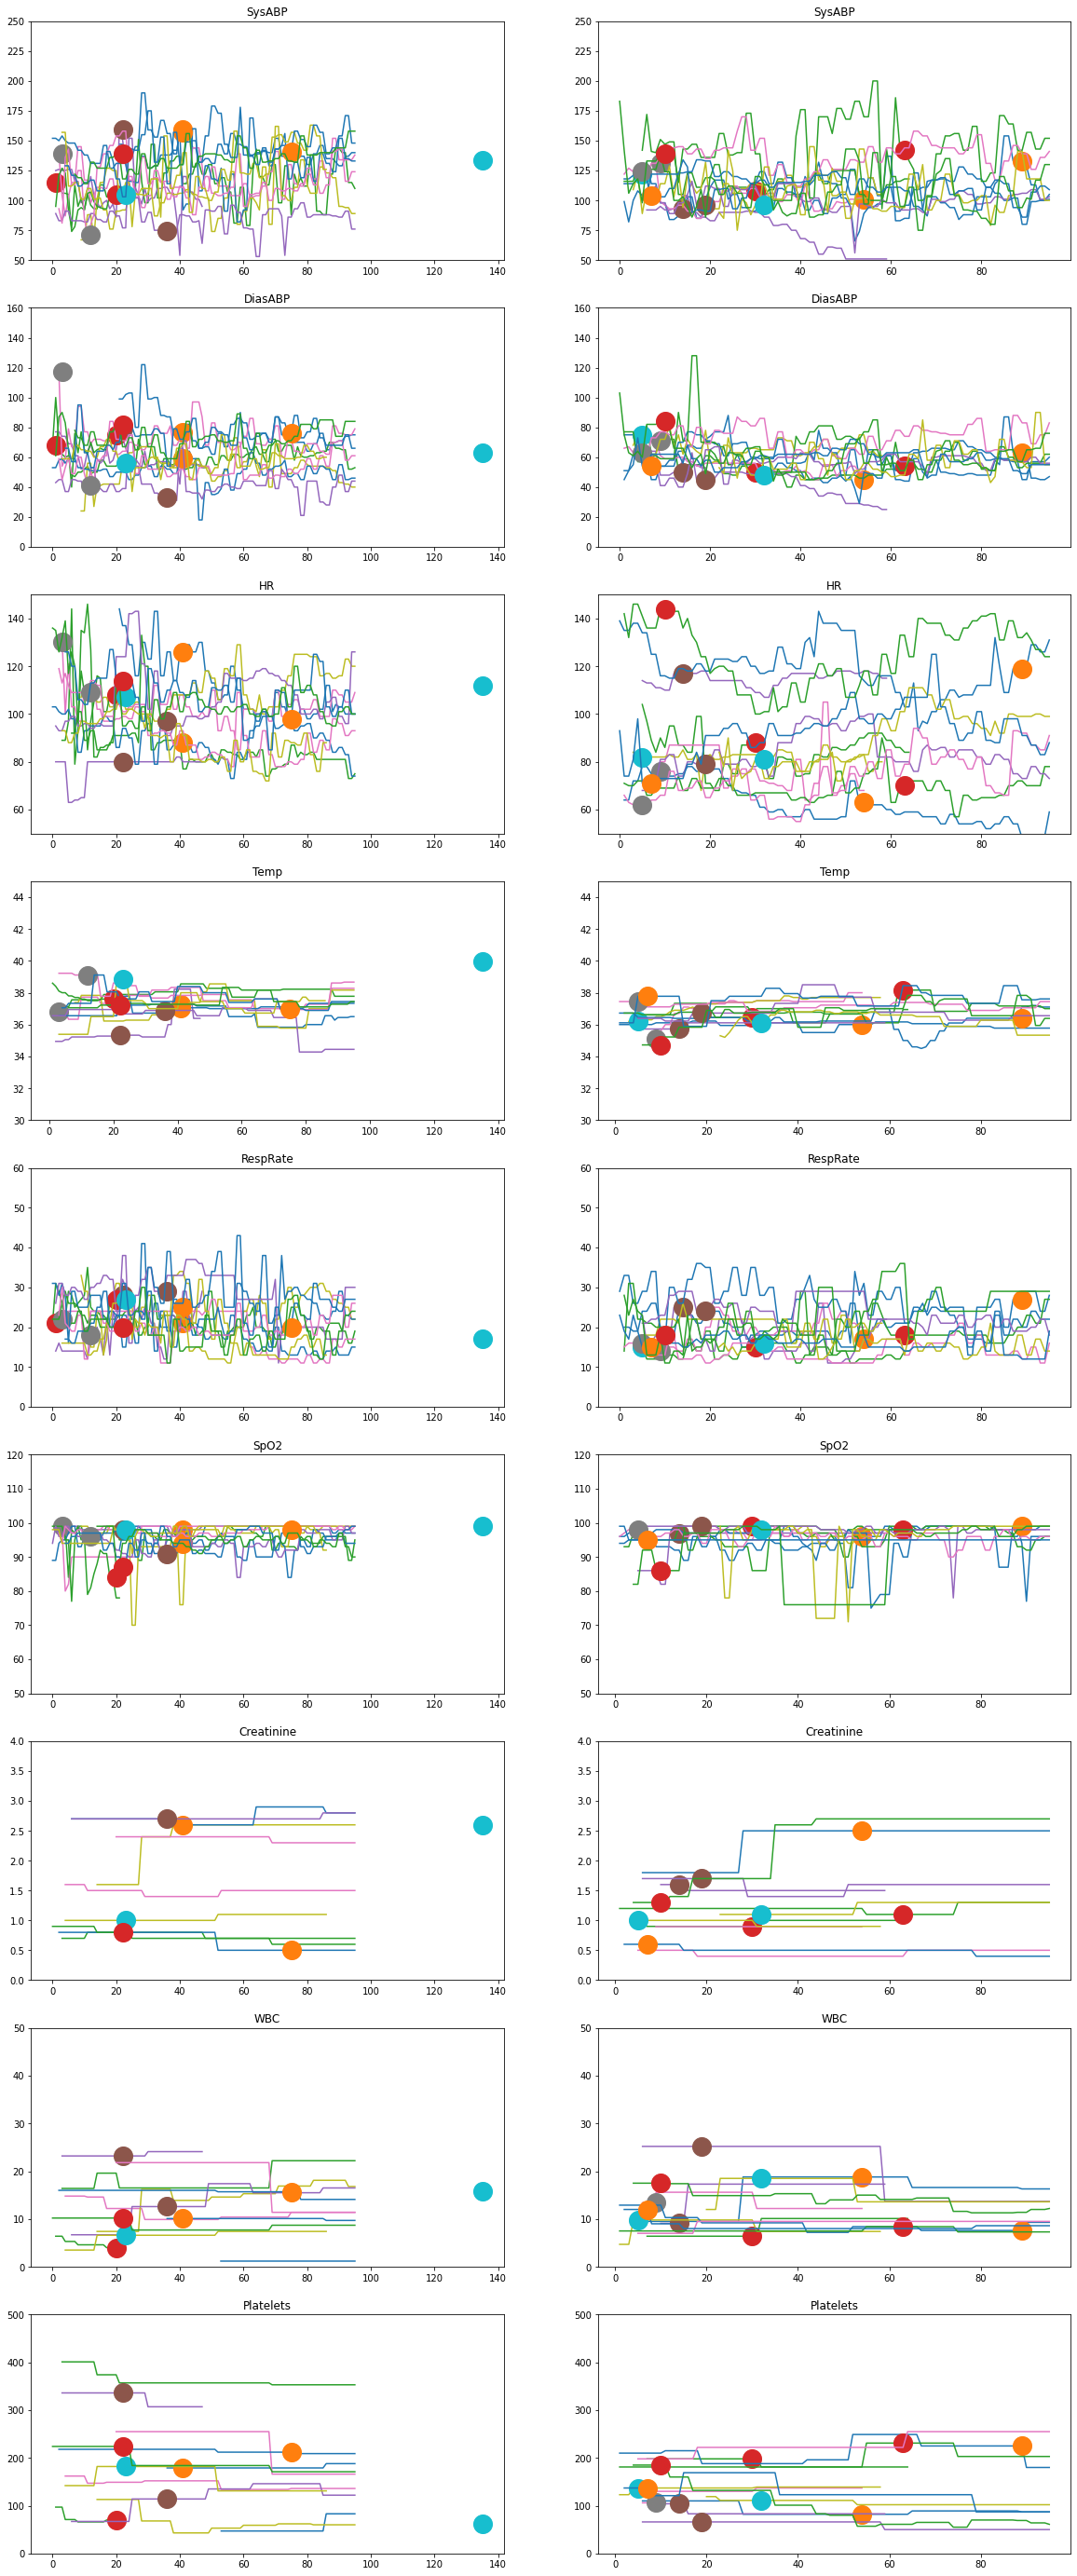

In [16]:
fig, axs = plt.subplots(9,2, figsize = (20,50))
#True samples and false samples are lists which contain the indices for true and cases in the keys dictionary.
true_samples = random.sample(true_cases, 12)
false_samples = random.sample(false_cases, 12)

#Every Feature/Vital
for i in range(9):

    for x in true_samples:
        period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
        start_time = datetime.strptime(berlin_ards[keys[x]]['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
        stop_time = datetime.strptime(berlin_ards[keys[x]]['Info']['is_Berlin_time'], '%Y-%m-%dT%H:%M:%S')
        time_mins = (stop_time - start_time).total_seconds()/60
        time_measure = time_mins/60
        time_period = round(time_measure * (60/period))
        
        
        axs[i][0].plot(berlin_ards[keys[x]]['feature_matrix'][i][:round(24*2*60/period)])
        axs[i][0].plot(time_period, berlin_ards[keys[x]]['feature_matrix'][i][(time_period)-1],'o', markersize=20)
        axs[i][0].set_title(enc['feature_matrix_row_names'][i])

    for x in false_samples:
        period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
        start_time = datetime.strptime(berlin_ards[keys[x]]['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
        stop_time = datetime.strptime(berlin_ards[keys[x]]['Info']['is_Berlin_time'], '%Y-%m-%dT%H:%M:%S')
        time_mins = (stop_time - start_time).total_seconds()/60
        time_measure = time_mins/60
        time_period = round(time_measure * (60/period))
        
        axs[i][1].plot(berlin_ards[keys[x]]['feature_matrix'][i][:round(24*2*60/period)])
        axs[i][1].plot(time_period, berlin_ards[keys[x]]['feature_matrix'][i][(time_period)-1],'o', markersize=20)
        axs[i][1].set_title(enc['feature_matrix_row_names'][i])


axs[0][0].set_ylim(50,250)
axs[1][0].set_ylim(0,160)
axs[2][0].set_ylim(50,150)
axs[3][0].set_ylim(30,45)
axs[4][0].set_ylim(0,60)
axs[5][0].set_ylim(50,120)
axs[6][0].set_ylim(0,4)
axs[7][0].set_ylim(0,50)
axs[8][0].set_ylim(0,500)
axs[0][1].set_ylim(50,250)
axs[1][1].set_ylim(0,160)
axs[2][1].set_ylim(50,150)
axs[3][1].set_ylim(30,45)
axs[4][1].set_ylim(0,60)
axs[5][1].set_ylim(50,120)
axs[6][1].set_ylim(0,4)
axs[7][1].set_ylim(0,50)
axs[8][1].set_ylim(0,500)

# These are graphs of 10 random patients and their vitals measured over time. The left side are the true cases and the left are the false ones. The dots signify the time which they were tested for ARDS.

# Data Preprocessing and storing into DataFrame

In [17]:
features = enc['feature_matrix_row_names']
cases_all_df = pd.DataFrame(index = range(len(keys)), columns = range(48))

#Every patient's data plus/minus five vital measurements is stored in the dataframe.
#There is a lot of missing data however and a lot of cases where the vitals 
#measured for ARD wasn't within the time frame or was nan.
#This part was extremely difficult, due to missing values and ARD time not syncing with vital measurements.

for x in range(len(keys)):
    period = berlin_ards[keys[x]]['feature_sampling_interval_minutes']
    start_time = datetime.strptime(berlin_ards[keys[x]]['Info']['first_measurement_time'], '%Y-%m-%dT%H:%M:%S')
    stop_time = datetime.strptime(berlin_ards[keys[x]]['Info']['is_Berlin_time'], '%Y-%m-%dT%H:%M:%S')
    time_mins = (stop_time - start_time).total_seconds()/60
    time_measure = abs(time_mins)/60
    time_period = round(time_measure * (60/period))
    if time_period <= 0.5:
        time_period = round(time_period + 0.51) - 1
    else:
        time_period = time_period - 1
    list2 = []
    list3 = []
    #print(period, time_measure, time_period)

    for i in range(9):
        if time_period > len(berlin_ards[keys[x]]['feature_matrix'][i][:]):
            break


        if math.isnan(berlin_ards[keys[x]]['feature_matrix'][i][time_period]) == True:
            list3 = (np.array(berlin_ards[keys[x]]['feature_matrix'][i][:]))
            nan_array = np.isnan(list3)
            list3_nans = list3[nan_array]
            if len(list3_nans) >= len(list3)/2:
                #print(x)
                break
                
            else:
                if time_period >= len(list3)/2:
                    nan_array = np.isnan(list3)
                    not_nan_array = ~ nan_array
                    list3 = list3[not_nan_array]
                    list2.append(list3[-5: ])
                else:
                    nan_array = np.isnan(list3)
                    not_nan_array = ~ nan_array
                    list3 = list3[not_nan_array]
                    list2.append([list3[0]] * 5)  

        elif math.isnan(berlin_ards[keys[x]]['feature_matrix'][i][time_period-1]) == True:
            list2.append([berlin_ards[keys[x]]['feature_matrix'][i][time_period]] * 5)

        else:
            for z in range(0, time_period):
                if math.isnan(berlin_ards[keys[x]]['feature_matrix'][i][z]) == True:
                    continue
                else:
                    if time_period < 5:
                        length = len(berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                        list2.append([berlin_ards[keys[x]]['feature_matrix'][i][z]] * (5-length)
                                     + berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                        break
                    else:
                        if (time_period + 1) - z >= 5:
                            list2.append(berlin_ards[keys[x]]['feature_matrix'][i][(time_period + 1) - 5: time_period + 1])
                            break
                        else:
                            length = len(berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                            list2.append([berlin_ards[keys[x]]['feature_matrix'][i][z]] * (5 - length) 
                                         + berlin_ards[keys[x]]['feature_matrix'][i][z: time_period + 1])
                            break
                            
    list2_arr = np.array(list2) 
    if list2_arr.size == 45:
        cases_all_df.at[x, :44] = np.reshape(list2_arr, (1,45))
        cases_all_df.at[x, 45] = time_period
        cases_all_df.at[x, 46] = x
        if x in false_cases:
            cases_all_df.at[x, 47] = 'False'
        else:
            cases_all_df.at[x, 47] = 'True'
    else:
        continue

In [18]:
#Drop all NaN columns
cases_all_df = cases_all_df.dropna()
cases_all_df.reset_index(drop = True, inplace = True)

In [19]:
cases_all_df = cases_all_df.rename(columns={47: "Class"})
cases_all_df = cases_all_df.rename(columns={46: "Index"})

In [20]:
#Converting class to binary
false_cases = []
true_cases = []
for index, row in cases_all_df.iterrows():
    if row['Class'] == 'False':
        cases_all_df.at[index, 'Class'] = 0
        false_cases.append(row['Index'])
    else:
        cases_all_df.at[index, 'Class'] = 1
        true_cases.append(row['Index'])

In [21]:
cases_all_df = cases_all_df.drop(columns = [45, 'Index'], axis = 1)

Class Imbalance

In [22]:
cases_all_df['Class'].value_counts()

0    6859
1     372
Name: Class, dtype: int64

In [23]:
cases_all_df['Class'] = cases_all_df['Class'].astype(int)

# Model

In [24]:
X = np.array(cases_all_df.iloc[: , :-1])
Y = np.array(cases_all_df.iloc[: , -1])

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from numpy import mean

In [26]:
Y = np.reshape(Y, (Y.shape[0], 1))
Y.shape

(7231, 1)

In [27]:
X.shape

(7231, 45)

In [28]:
# steps = [('over', SMOTE()), ('model', RandomForestClassifier())]
# pipeline = Pipeline(steps=steps)
# # evaluate pipeline
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=1)
# scores = cross_val_score(pipeline, X, Y, scoring='roc_auc', cv=cv, n_jobs=-1)
# print('Mean ROC AUC: %.3f' % mean(scores))

Data Splitting/ Oversampling on Training Data to account for Imbalanced data using SMOTE

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42, stratify = Y, shuffle = True)

In [30]:
type(Y_train)

numpy.ndarray

In [31]:
smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X_train, Y_train)

print('Original dataset shape', Counter(Y_train[:,0]))
print('Resample dataset shape', Counter(y_smote))

Original dataset shape Counter({0: 5830, 1: 316})
Resample dataset shape Counter({1: 5830, 0: 5830})


Random Forest Classifier

In [32]:
rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, Y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('Accuracy score:',accuracy_score(Y_test, rfc_predict))

<ipython-input-32-d79a10563239>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, Y_train)


Accuracy score: 0.9483870967741935


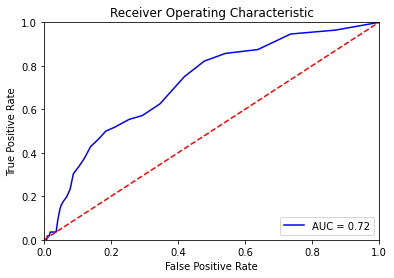

In [33]:
probs = rfc.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(Y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [34]:
cases_true_df = cases_all_df[cases_all_df['Class'] == 1]
cases_false_df = cases_all_df[cases_all_df['Class'] == 0]
cases_true_df.reset_index(drop = True, inplace = True)
cases_false_df.reset_index(drop = True, inplace = True)
cases_resampled_df = pd.DataFrame(x_smote, columns = range(0, 45))
cases_resampled_df['Class'] = y_smote
cases_true_resample_df = cases_resampled_df[cases_resampled_df['Class'] == 1]
cases_false_resampled_df = cases_resampled_df[cases_resampled_df['Class'] == 0]

# Means of Each Distribution(LEFT SIDE: TRUE CASES, RIGHT: FALSE)

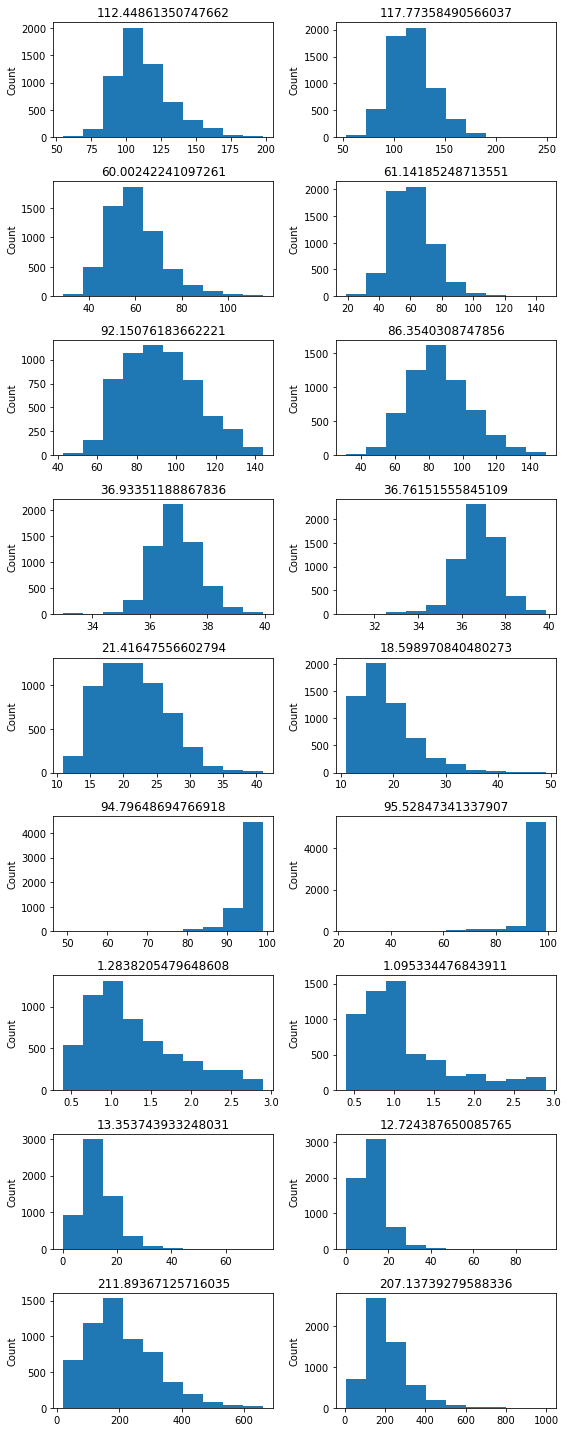

In [35]:
#Histogram for each person and total counted values for each vital over time.

fig, axs = plt.subplots(9,2, figsize = (8,20))
count = 0
i = 0
for x in range(4, 45, 5):
    count = count + 1
    axs[x-(4* count)][0].hist(cases_true_resample_df.iloc[ : , x])
    axs[x-(4* count)][0].set_title(cases_true_resample_df.iloc[ : , x].mean())
    axs[x-(4* count)][0].set_ylabel('Count')
# cases_true_resample_df.iloc[ : , x].mean()
# cases_true_resample_df.iloc[ : , x].var()    
    
    axs[x-(4* count)][1].hist(cases_false_resampled_df.iloc[ : , x])
    axs[x-(4* count)][1].set_title(cases_false_resampled_df.iloc[ : , x].mean())
    axs[x-(4* count)][1].set_ylabel('Count')  
    
    i = i + 1
    
fig.tight_layout()

# Patients who tested positive for ARDS on average had a lower Systolic Blood Pressure, a higher Heart Rate, a Higher Respiration Rate, and a higher Platelets Count